## Tutorial Portfolio Allocation with BNP Paribas Asset Management

Notebook by Max Pommier, Hugo Yérémian, Simon Teherc, William Roche and Ethan Trentin. 

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.optimize import minimize

Exercice 1 : Efficient frontier 

We will first define the correlation matrix $\rho$ and the vector of volatility $\sigma$ for the stocks AAPL (Apple), GOOGL (Google), MSFT (Microsoft), AMZN (Amazon), META (Meta), TSLA (Tesla), GS (Goldman Sachs) & Cash. 

In [16]:
mu = np.array([0.072,0.032,0.067,0.039,0.063,0.052,0.05,0])
sigma = np.array([0.18,0.12,0.16,0.13,0.14,0.13,0.12,0.005])
rho = np.array([[1,   0.47, 0.38, 0.35, 0.40, 0.25, 0.80, 0], 
               [0.47,    1, 0.10, 0.15, 0.75,-0.20, 0.36, 0], 
               [0.38, 0.10,    1,-0.23, 0.05, 0.10, 0.25, 0], 
               [0.35, 0.15,-0.23,    1,-0.23, 0.11, 0.13, 0],
               [0.40, 0.75, 0.05,-0.23, 1,   -0.08, 0.31, 0],
               [0.25,-0.20, 0.10, 0.11,-0.08,    1, 0.64, 0],
               [0.80, 0.36, 0.25, 0.13, 0.31, 0.64,    1, 0],
               [0,       0,    0,    0,    0,    0,    0, 1]])
kappa = 0.2

In [8]:
## Just to check that rho was correctly defined
rho.T == rho

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [10]:
## We define the covariance matrix thanks to the correlation matrix
n = len(mu) # Number of stocks considered
Sigma = np.zeros((n,n))
for i in range(n):
  for j in range(n):
    Sigma[i,j] = rho[i,j]*sigma[i]*sigma[j]
Sigma

array([[ 3.2400e-02,  1.0152e-02,  1.0944e-02,  8.1900e-03,  1.0080e-02,
         5.8500e-03,  1.7280e-02,  0.0000e+00],
       [ 1.0152e-02,  1.4400e-02,  1.9200e-03,  2.3400e-03,  1.2600e-02,
        -3.1200e-03,  5.1840e-03,  0.0000e+00],
       [ 1.0944e-02,  1.9200e-03,  2.5600e-02, -4.7840e-03,  1.1200e-03,
         2.0800e-03,  4.8000e-03,  0.0000e+00],
       [ 8.1900e-03,  2.3400e-03, -4.7840e-03,  1.6900e-02, -4.1860e-03,
         1.8590e-03,  2.0280e-03,  0.0000e+00],
       [ 1.0080e-02,  1.2600e-02,  1.1200e-03, -4.1860e-03,  1.9600e-02,
        -1.4560e-03,  5.2080e-03,  0.0000e+00],
       [ 5.8500e-03, -3.1200e-03,  2.0800e-03,  1.8590e-03, -1.4560e-03,
         1.6900e-02,  9.9840e-03,  0.0000e+00],
       [ 1.7280e-02,  5.1840e-03,  4.8000e-03,  2.0280e-03,  5.2080e-03,
         9.9840e-03,  1.4400e-02,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.5000e-05]])

In [30]:
Omega = np.diag(np.diag(Sigma))
Omega

array([[3.24e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 1.44e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 2.56e-02, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 1.69e-02, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.96e-02, 0.00e+00,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.69e-02,
        0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.44e-02, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.50e-05]])

a. Plot the efficient frontier based on Markowitz optimization with the following constraints : no investment in cash, short selling investment is allowed to one notional (-100%), leverage is allowed up to two notionals (200%) and we also have the constraint of full investment. Can you plot the
efficient frontier from a volatility of 12% until 18% ? 

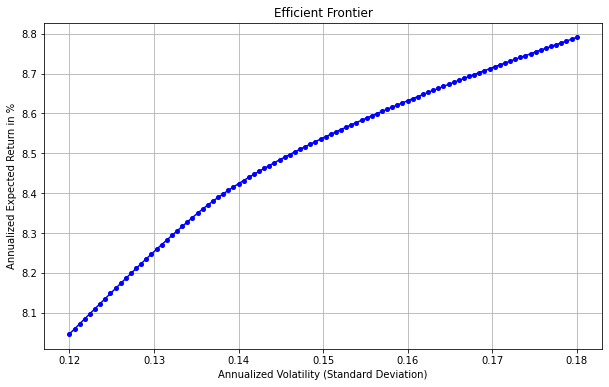

In [36]:
vector_risk = np.linspace(0.12, 0.18, 100)

expected_returns = []

for risk in vector_risk:
  w = cp.Variable(n)
  objective = cp.Maximize(mu.T @ w)
  constraints = [
    cp.sum(w) == 1,             # Full investment constraint
    w >= -1,                    # Short selling allowed up to -100% : it concerns each stock
    cp.norm1(w) <= 2,           # Leverage constraint (sum of absolute weights ≤ 200%) : the leverage is on the whole portfolio
    w[-1]==0,                    # No investment in cash
    w.T @ Sigma @ w <= risk**2, # Risk constraint
]

  prob = cp.Problem(objective, constraints)
  result = prob.solve()

  if prob.status == 'optimal':
    expected_returns.append(result*100)
  else:
    expected_returns.append(np.nan) # To handle cases where optimization fails

plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns, marker='o', linestyle='-', color = "b", markersize=4)
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

b. On the same chart, can you add the efficient frontier based on Robust Optimization with the same constraints ? 

Let's consider the following optimization problem :  
$$w_{rob} = argmax(\overline{\mu}^Tw-\kappa\sqrt{w^T \Omega w})$$

where $w_{rob}$ is the vector of the assets weights, $\overline{\mu}$ the vector of returns, $\kappa$ the return error aversion parameter and $\Omega$ the error variance-covariance matrix.

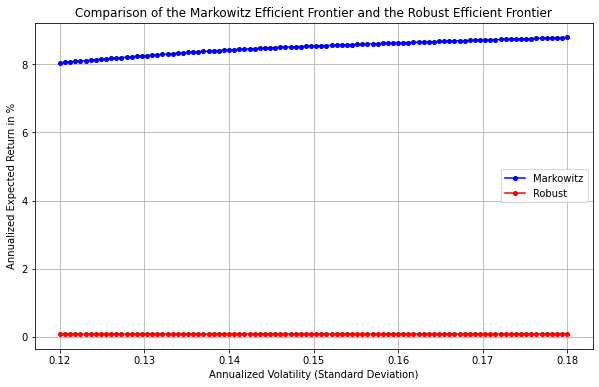

In [39]:
def objective_function(w):
    return - (mu.T @ w - kappa * np.sqrt(w.T @ Omega @ w))

def constraint_sum_to_one(w):
    return np.sum(w) - 1

def constraint_short_selling(w):
    return w+1

def constraint_leverage(w):
    return 2 - np.sum(np.abs(w))

# Bounds for weights
bounds = [(0, 0) if i == n-1 else (-1, 2) for i in range(n)]
 # So we have w[-1]=0 meaning no investment on cash.

robust_returns = []

for risk in vector_risk:
    # Initial guess for weights (e.g., equally weighted)
    w0 = np.ones(n) / n

    def constraint_risk(w):
        return risk**2-w.T @ Sigma @ w  
    # Constraints definition for scipy.optimize.minimize
    constraints = ({'type': 'eq', 'fun': constraint_sum_to_one},
                {'type': 'ineq', 'fun': constraint_short_selling},
                {'type': 'ineq', 'fun': constraint_risk},
                {'type': 'ineq', 'fun': constraint_leverage})
    # Optimization
    result = minimize(objective_function, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    # Print results
    if result.success:
        w_rob = result.x
        robust_returns.append(mu @ w_rob)


plt.figure(figsize=(10, 6))
plt.plot(vector_risk, expected_returns, marker='o', linestyle='-', color = "b", markersize=4, label = "Markowitz")
plt.plot(vector_risk, robust_returns, marker='o', linestyle='-', color = "r", markersize=4, label = "Robust")
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Expected Return in %')
plt.title('Comparison of the Markowitz Efficient Frontier and the Robust Efficient Frontier')
plt.grid(True)
plt.legend()
plt.show()

c. Explain these results ! 